## Comparison of different max #nodes or max time thresholds

In [ ]:
# import
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import json
import os
import pathlib

#set path to folder
folder = "../../../eval-results/_server-results/test9"
net_analysis = "../../../eval-results/_server-results/net-BP-birth/net.eval" 

In [ ]:
#fetch data 
dir_list = next(os.walk(folder))[1]
dfs = []
#merge all 
for subfolder in dir_list:
    #print(subfolder)
    evalFile = folder +"/" + subfolder +"/aggResults.eval"
    confFile = folder +"/" + subfolder +"/config.log"
    if os.path.exists(evalFile):
        df = pd.read_csv(evalFile ,encoding="ISO-8859-1", skipinitialspace=True)
        with open(confFile) as json_file:
            conf = json.load(json_file)
        #add config information to dataframe 
        df['matcher'] = conf['matcher']['ilp'] + " - " + conf['matcher']['profile'] +" - " + str(conf['matcher']['word-sim']) + " - sim-weight=" + str(conf['matcher']['sim-weight']) + " - match-postprocessing=" + str(conf['matcher']['postprocessing-thresh'] ) + " - Node Limit: " +str(conf['matcher']['ilp-node-limit']) + "- Time Limit : " +str(conf['matcher']['ilp-time-limit'])
        df['matcher_wo_weight'] = conf['matcher']['ilp'] + " - " + conf['matcher']['profile'] +" - " + str(conf['matcher']['word-sim']) + " - match-postprocessing=" + str(conf['matcher']['postprocessing-thresh']) + " - Node Limit: " +str(conf['matcher']['ilp-node-limit']) + "- Time Limit : " +str(conf['matcher']['ilp-time-limit'])
        df['matcher_wo_limit'] = conf['matcher']['ilp'] + " - " + conf['matcher']['profile'] +" - " + str(conf['matcher']['word-sim']) + " - sim-weight=" + str(conf['matcher']['sim-weight']) + " - match-postprocessing=" + str(conf['matcher']['postprocessing-thresh'] )
        df['complex-matches'] = conf['matcher']['complex matches']
        df['profile'] = conf['matcher']['profile']
        df['ilp'] =  conf['matcher']['ilp']
        df['word-sim'] =  conf['matcher']['word-sim']
        df['sim-weight'] = conf['matcher']['sim-weight']
        df['matcher-postprocessing-threshold'] = conf['matcher']['postprocessing-thresh']
        df['eval-postprocessing-threshold'] = conf['evaluation']['postprocessing-thresh']
        df['ILP-time-limit'] = conf['matcher']['ilp-time-limit']
        df['ILP-node-limit'] = conf['matcher']['ilp-node-limit']
        
        #df.set_index(['Name','matcher'])
        dfs.append(df)
        
df_combined = pd.concat(dfs)

#convert time
df_combined['OVERALL TIME'] = df_combined['OVERALL TIME'].map(lambda x: x / 1000000000.)
df_combined['BP TIME'] = df_combined['BP TIME'].map(lambda x: x / 1000000000.)
df_combined['LABEL-SIM TIME'] = df_combined['LABEL-SIM TIME'].map(lambda x: x / 1000000000.)
df_combined['LP TIME'] = df_combined['LP TIME'].map(lambda x: x / 1000000000.)

#extend with net information stored in net_analysis
df_nets = pd.read_csv(net_analysis ,encoding="ISO-8859-1", skipinitialspace=True)
#df_nets.set_index('Name')

def net1adder(row):
    #get net names
    if row['Name'] != "Aggregated (MICRO)" and row['Name'] != "Aggregated (MACRO)":
        return row['Name'].split('-')[0].replace(".pnml","")
    else:
        return 0
def net2adder(row):        
    if row['Name'] != "Aggregated (MICRO)" and row['Name'] != "Aggregated (MACRO)":
        return row['Name'].split('-')[1].split('.')[0].replace(".pnml","")
    else: 
        return 0
    
def pnml_remover(row):
    #get net names
    if row['Name'] != "Aggregated (MICRO)" and row['Name'] != "Aggregated (MACRO)":
        return row['Name'].replace(".pnml","").replace(".rdf","")
    else:
        return row['Name']

def net1NonTaus(row):
    if row['Name'] != "Aggregated (MICRO)" and row['Name'] != "Aggregated (MACRO)":
        return df_nets.at[row['net1'],'nNonSilentTransitions'] 
    else:
        return 0
def net2NonTaus(row):
    if row['Name'] != "Aggregated (MICRO)" and row['Name'] != "Aggregated (MACRO)":
        return df_nets.at[row['net2'],'nNonSilentTransitions'] 
    else:
        return 0
def sumNonTaus(row):    
    if row['Name'] != "Aggregated (MICRO)" and row['Name'] != "Aggregated (MACRO)":
        return row['net1NonTaus'] + row['net2NonTaus']
    else:
        return 0
    
df_combined['net1'] = df_combined.apply(lambda row: net1adder(row), axis=1)
df_combined['net2'] = df_combined.apply(lambda row: net2adder(row), axis=1)
df_combined['net1NonTaus'] = df_combined.apply(lambda row: net1NonTaus(row), axis=1)
df_combined['net2NonTaus'] = df_combined.apply(lambda row: net2NonTaus(row), axis=1)
df_combined['sumNonTaus'] = df_combined.apply(lambda row: sumNonTaus(row), axis=1)
df_combined['Name'] = df_combined.apply(lambda row: pnml_remover(row), axis=1)


In [ ]:
#time analysis

df_ = df_combined[df_combined["Name"] != "Aggregated (MICRO)"]
df_ = df_[df_["Name"] != "Aggregated (MACRO)"]

# time wrt behavioral share
fig, (ax1) = plt.subplots(1,1)
fig.set_size_inches(18.5, 5.25)
sns.lineplot(x="sim-weight", y="LP TIME", hue="matcher_wo_weight", data=df_, ax=ax1);
plt.title("LP Time wrt sim weight")


In [ ]:
# results of precision recall and fscore
# we conclude the error on the result is pretty low when setting the time limit lower

# Avg Precisision Recall Fscore over postprocessing threshold
df_macro_avg = df_combined[df_combined.Name == "Aggregated (MACRO)"]
df_micro_avg = df_combined[df_combined.Name == "Aggregated (MICRO)"]


#calculate the difference between the maximum recall/precision/fscore and the minimum
#thats how we show that the reduction of time does not effect the results
df_macro_avg = df_macro_avg.groupby(['sim-weight','eval-postprocessing-threshold'])['RECALL','PRECISION','FSCORE'].agg(np.ptp)
df_macro_avg.reset_index(inplace=True)
df_micro_avg = df_micro_avg.groupby(['sim-weight','eval-postprocessing-threshold',])['RECALL','PRECISION','FSCORE'].agg(np.ptp)
df_micro_avg.reset_index(inplace=True) 

# fix a seabor bug that doesnt allow for categorical hue
diff_values = len(df_macro_avg.groupby(['sim-weight']))
df_macro_avg['sim-weight'] = df_macro_avg['sim-weight'].astype(str)
df_micro_avg['sim-weight'] = df_micro_avg['sim-weight'].astype(str)

#visualize it
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18.5, 5.25)
fig.suptitle("Difference between 1 hour and 20 minutes max ILP runtime")
sns.lineplot(x="eval-postprocessing-threshold", y="RECALL", hue="sim-weight", data=df_macro_avg, ax = ax1,  palette=sns.color_palette(None,diff_values));
ax1.set_title("Macro")
ax1.get_legend().remove()
sns.lineplot(x="eval-postprocessing-threshold", y="RECALL", hue="sim-weight", data=df_micro_avg, ax = ax2,  palette = sns.color_palette(None,diff_values));
ax2.set_title("Micro")
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18.5, 5.25)
sns.lineplot(x="eval-postprocessing-threshold", y="PRECISION", hue="sim-weight", data=df_macro_avg, ax = ax1, palette= sns.color_palette(None,diff_values));
ax1.set_title("Macro")
ax1.get_legend().remove()
sns.lineplot(x="eval-postprocessing-threshold", y="PRECISION", hue="sim-weight", data=df_micro_avg, ax = ax2, palette= sns.color_palette(None,diff_values));
ax2.set_title("Micro")
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18.5, 5.25)
sns.lineplot(x="eval-postprocessing-threshold", y="FSCORE", hue="sim-weight", data=df_macro_avg, ax = ax1, palette= sns.color_palette(None,diff_values));
ax1.set_title("Macro")
ax1.get_legend().remove()
sns.lineplot(x="eval-postprocessing-threshold", y="FSCORE", hue="sim-weight", data=df_micro_avg, ax = ax2, palette= sns.color_palette(None,diff_values));
ax2.set_title("Micro")
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [34]:
#read gurobi file function
def read_gurobi(file):
    delete = True
    objective_value = -1
    cleaned = "cleaned.log"
    infile = open(file,'r').readlines()
    with open(cleaned,'w') as outfile:
        for index, line in enumerate(infile):
            if "Cutting plane" in line:
                delete = True
            if "Explored" in line:
                delete = True
            if "Best" in line and "objective" in line:
                objective_value = line.split()[2].replace(',','')
            if " Expl" in line and "It/Node Time" in line:
                delete = False
            line = line.replace('H','').replace('s','').replace('|.1','').replace('|.2','').replace('|','').replace('*','')
            if not delete:
                outfile.write(line)   
            

    #read table
    gurobi_df =pd.read_csv(cleaned, delim_whitespace=True, encoding="ISO-8859-1")
    gurobi_df=gurobi_df.dropna()
    
    #handle empty dataframes, resulting from immediate solving
    if gurobi_df.empty:
        gurobi_df = gurobi_df.append(pd.Series(), ignore_index=True)
        gurobi_df['Expl'] = 0
        gurobi_df['Unexpl'] = 0
        gurobi_df['IntInf'] = 0
        gurobi_df['Depth'] = 0
        gurobi_df['Incumbent'] = float(objective_value)
        gurobi_df['Obj'] = 0
        gurobi_df['BetBd'] = float(objective_value)
        gurobi_df['Gap'] = 0.00
        gurobi_df['Time'] = 0
        gurobi_df['It/Node'] = 0
        return gurobi_df
    
    #drop duplicate columns resulting from kicking Heuristic solutions
    gurobi_df.drop_duplicates(keep='first',subset=['Time'])
    #add missing values
    last_row = gurobi_df.iloc[[0]]
    for i in range(3601):
        #if there is a at least one row for that time stamp take the last row of that stamp
        #if not inser new row but with time shifted
        if (gurobi_df['Time'] == i).any():
            last_row = gurobi_df.loc[gurobi_df['Time'] == i].iloc[[0]] 
        else:
            last_row['Time'] = i
            gurobi_df = gurobi_df.append(last_row)
        
        
    
    #typing
    gurobi_df['Expl'] = gurobi_df['Expl'].astype(int)
    gurobi_df['Time'] = gurobi_df['Time'].astype(int)
    gurobi_df['Incumbent'] = gurobi_df['Incumbent'].astype(float)
    
    #set final found objective
    gurobi_df['final objective'] = float(objective_value)
    
    #Difference between final objective value and incumbent
    gurobi_df['abs_diff'] = gurobi_df.apply(lambda row: difference(row), axis=1)
    gurobi_df['rel_diff'] = gurobi_df.apply(lambda row: rel_difference(row), axis=1)
    return gurobi_df

def rel_difference(row):
    if row['final objective'] < 0:
        return 0
    else:
        return (row['final objective'] - row['Incumbent']) / row['final objective']


def difference(row): 
    if row['final objective'] < 0:
        return 0
    else:
        return row['final objective'] - row['Incumbent']

    Expl  Unexpl      Obj  Depth IntInf Incumbent    BetBd    Gap It/Node  \
0      0       0  0.87413    0.0     99   0.44543  0.87413  96.2%       -   
4      0       0  0.87413    0.0     99   0.68437  0.87413  27.7%       -   
5      0       0  0.87413    0.0     99   0.68437  0.87413  27.7%       -   
6      0       0  0.87413    0.0    125   0.68437  0.87413  27.7%       -   
7      0       0  0.87413    0.0    125   0.68437  0.87413  27.7%       -   
8      0       2  0.87413    0.0    103   0.68437  0.87413  27.7%       -   
9     15      32  0.87413    4.0    103   0.68437  0.87413  27.7%    1220   
14    51      72  0.87413    6.0    168   0.73813  0.87413  18.4%    1439   
15   406     402  0.87413   20.0    173   0.73813  0.87413  18.4%     475   
16  1535    1511  0.87413   73.0    127   0.73813  0.87413  18.4%     249   
18  2581    2525  0.87158  101.0    129   0.73813  0.87413  18.4%     242   
19  2634    2577  0.86558   98.0    164   0.73813  0.87413  18.4%     241   

/Users/dominikhuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


    Expl  Unexpl      Obj  Depth IntInf Incumbent    BetBd    Gap It/Node  \
0      0       0  0.87137    0.0    134   0.45405  0.87137  91.9%       -   
4      0       0  0.87137    0.0    134   0.69094  0.87137  26.1%       -   
5      0       0  0.87137    0.0    138   0.69094  0.87137  26.1%       -   
6      0       0  0.87137    0.0    140   0.69094  0.87137  26.1%       -   
7      0       0  0.87137    0.0    140   0.69094  0.87137  26.1%       -   
8      0       2  0.87137    0.0    140   0.69094  0.87137  26.1%       -   
9      3       8  0.87137    2.0    140   0.69094  0.87137  26.1%     415   
12    51      72  0.87137    6.0    132   0.72319  0.87137  20.5%     974   
13    71      83  0.87137    6.0    130   0.72319  0.87137  20.5%     854   
14  1223    1167  0.87137   55.0    130   0.72319  0.87137  20.5%    75.5   
15  1970    1902  0.87137   81.0    130   0.72319  0.87137  20.5%    55.9   
16  2712    2637  0.87137  104.0    130   0.72319  0.87137  20.5%    46.5   

     Expl  Unexpl      Obj  Depth IntInf Incumbent    BetBd    Gap It/Node  \
0       0       0  0.87111    0.0     42   0.34593  0.87111   152%       -   
4       0       0  0.87111    0.0     42   0.59607  0.87111  46.1%       -   
5       0       0  0.87111    0.0     42   0.59607  0.87111  46.1%       -   
6       0       2  0.87111    0.0     42   0.59607  0.87111  46.1%       -   
13    931     573  0.85063   28.0     70   0.74750  0.86913  16.3%     159   
14   1684    1061  0.79115   25.0     56   0.74750  0.86446  15.6%     164   
15   2294    1507  0.85768   27.0     42   0.74750  0.86393  15.6%     156   
16   2297    1509  0.86083   12.0    886   0.74750  0.86393  15.6%     156   
17   2298    1510  0.83511   50.0   1748   0.74750  0.86359  15.5%     156   
18   2299    1510  0.80004   34.0   1825   0.74750  0.86286  15.4%     156   
19   2300    1511  0.85651   22.0   1815   0.74750  0.86286  15.4%     156   
21   2302    1439  0.86264   11.0   1458   0.76816  0.86286  12.

     Expl  Unexpl      Obj  Depth IntInf Incumbent    BetBd    Gap It/Node  \
0       0       0  0.85421    0.0    132   0.44712  0.85421  91.0%       -   
4       0       0  0.85421    0.0    132   0.68155  0.85421  25.3%       -   
5       0       0  0.85421    0.0    132   0.68155  0.85421  25.3%       -   
6       0       0  0.85421    0.0    132   0.68155  0.85421  25.3%       -   
7       0       0  0.85421    0.0    132   0.68155  0.85421  25.3%       -   
8       0       2  0.85421    0.0    132   0.68155  0.85421  25.3%       -   
9       3       8  0.85421    2.0    132   0.68155  0.85421  25.3%    2966   
12     51      72  0.85421    6.0    158   0.74665  0.85421  14.4%    2104   
13    214     208  0.85421   14.0    158   0.74665  0.85421  14.4%     820   
14    381     356  0.85421   24.0    165   0.74665  0.85421  14.4%     514   
15    533     479  0.85421   26.0    156   0.74665  0.85421  14.4%     438   
16    563     505  0.85401   14.0    193   0.74665  0.85421  14.

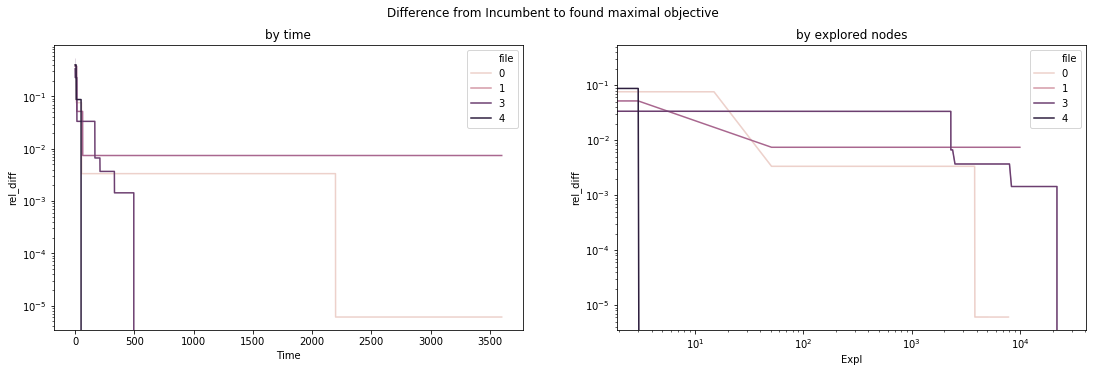

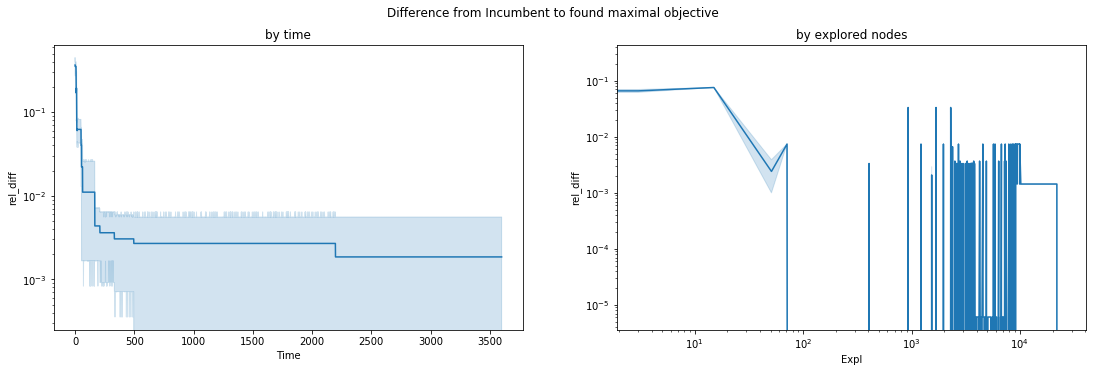

In [35]:
#THIS TAKES HELL OF A TIME! CAUTION
folder = "../../../eval-results/_server-results/test14/gurobi-logs-tmp/"
df_gurobi_combined = []

dir_list = next(os.walk(folder))[2]
dir_list
for index,file in  enumerate(dir_list):
    if ".log" in file:
        df_gurobi = read_gurobi(folder + file)
        df_gurobi['file'] = index
        df_gurobi_combined.append(df_gurobi)
df_gurobi_combined = pd.concat(df_gurobi_combined)  
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle("Difference from Incumbent to found maximal objective")
fig.set_size_inches(18.5, 5.25)
ax1.set(yscale="log")
sns.lineplot(x="Time", y="rel_diff", hue="file", data=df_gurobi_combined, ax = ax1);
ax1.set_title("by time")

ax2.set(yscale="log", xscale="log")
ax2.set_title("by explored nodes")
sns.lineplot(x="Expl", y="rel_diff", hue="file", data=df_gurobi_combined, ax = ax2);

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle("Difference from Incumbent to found maximal objective")
fig.set_size_inches(18.5, 5.25)
ax1.set(yscale="log")
sns.lineplot(x="Time", y="rel_diff", data=df_gurobi_combined, ax = ax1);
ax1.set_title("by time")

ax2.set(yscale="log", xscale="log")
ax2.set_title("by explored nodes")
sns.lineplot(x="Expl", y="rel_diff", data=df_gurobi_combined, ax = ax2);


